# Preparation

Before you study, please install the following necessary packages.

In [1]:
!pip install lifelines
! pip install sklearn-pandas
! pip install torchtuples
! pip install optunity
! pip install statsmodels --upgrade
! pip install pycox
! pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Next patch mounts the directory to the Google drive, which means you can source the local codes and data files. Feel free to remove this patch if you do not use Google Colabtorary as the IDE.

In [2]:
from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/Kevin He"
# %pwd
# from pycox.models import LogisticHazard

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kevin He


`data_simulation` is the simulation codes that used for simulating data for our experiments, `read_data` is a class that can be used to generate different datasets, `KLDL` wraps necessary components.

In [3]:
import os
import sys
import time

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch # For building the networks 
import torch.nn as nn
import torch.nn.functional as F
import torchtuples as tt

from random import sample

import KLDL
from KLDL import NewlyDefinedLoss
from KLDL import NewlyDefinedLoss2
import data_simulation
import read_data
import Structure

In [4]:
np.random.seed(1234)
_ = torch.manual_seed(1234)

If you have mounted the data rightly, you should print out the list for files in given folder. For example, this will print out all files in `/content/drive/My Drive/Kevin He`. Same, feel free to remove this patch if you do not use Google Colabtorary.

In [5]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Kevin He"
GOOGLE_DRIVE_PATH = os.path.join("/content/drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['weight_checkpoint_2022-9-12_19-49-31_T8sDGBwklwxRzfjjaVDw.pt', 'weight_checkpoint_2022-9-12_19-49-37_hEposWT6I7BTRGiRRXBS.pt', 'weight_checkpoint_2022-9-12_19-49-42_WTOSuUHpPY7p38fbTuIL.pt', 'weight_checkpoint_2022-9-12_19-49-52_6qdXR3smEA3o4fWezgzH.pt', 'weight_checkpoint_2022-9-12_19-49-59_Cll3RNG5S9AyaLKeRZUu.pt', 'weight_checkpoint_2022-9-12_19-50-5_IubiQ5ERmnqjEkfCrXps.pt', 'weight_checkpoint_2022-9-12_19-50-15_W2JLB20NQ0mCm3zDXbb7.pt', 'weight_checkpoint_2022-9-12_19-50-21_TXso4SnDyrWVqaRtyFfS.pt', 'weight_checkpoint_2022-9-12_19-50-27_9R09kAlH4R4tyllHZjbp.pt', 'weight_checkpoint_2022-9-12_19-50-34_aExPHOtzTVFH6pslBbq0.pt', 'weight_checkpoint_2022-9-12_19-50-41_mNmRF7byC50AtyobDxcU.pt', 'weight_checkpoint_2022-9-12_19-50-47_j3Wj7K9vRaX9QlprS2cu.pt', 'weight_checkpoint_2022-9-12_19-50-54_DNRdzgJESAAKtdoJwbrz.pt', 'weight_checkpoint_2022-9-12_19-51-3_kucVa0IcF7vJ7Fm83mGm.pt', 'weight_checkpoint_2022-9-12_19-51-14_71M8892rjMxyKVmqxa0n.pt', 'weight_checkpoint_2022-9-12_19-51-29_kxo

# Read Data

In Survival Analysis, there are 3 link functions that are frequently used for modeling. Although deep learning demonstrates a high flexibility of modeling non-linear, non-proportional data, in many cases where data is shown to have some statistical properties, using deep learning will instead lead to an inferior result. That is the reason we still provide with an option to simulate a function that can be proportional in some cases. 

In general, we can uniformly define the model as 

$$
h[d \Lambda (t, x)] = h[d \Lambda_0 (t)] + Z(t)' \beta
$$

where $h$ is a monotone-increasing and twice-differentiable function mapping $[0, 1]$ into $[-\infty, \infty]$ with $h(0) = - \infty$. Then we have the following 3 options:

1. $h(u) = \log (- \log (1 - u))$ (grouped relative risk model)
2. $h(u) = \log u$ (discrete relative risk model)
3. $h(u) = \log \frac u {1 - u}$ (discrete logistic model)

The code patch is shown below


```
if(option == "log-log"):
  input = input + torch.log(-torch.log(torch.sigmoid(self.a)))
  input = 1 - torch.exp(-torch.exp(input))
  return input
elif(option == "log"):
  input = input + torch.log(torch.sigmoid(self.a))
  input = torch.exp(input)
  return input
elif(option == "logit"):
  return torch.sigmoid(input + self.a)
```



Here is an illustration that shows the details of the last 3 layers
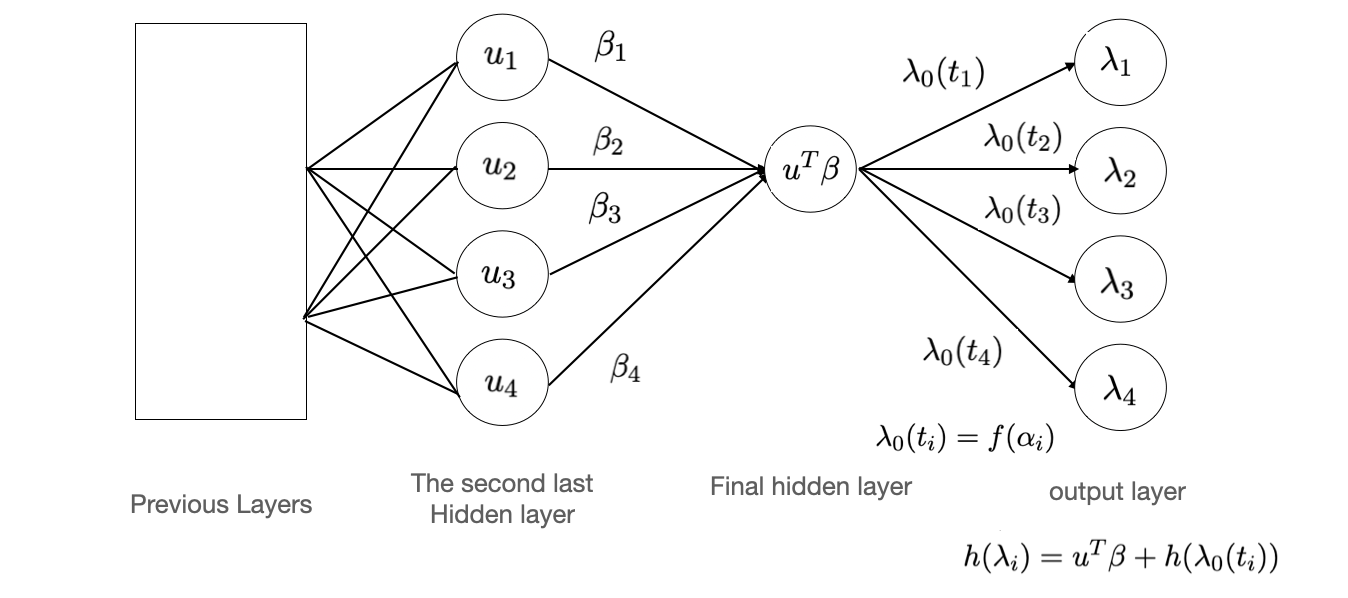

Here we assume that the number of nodes in the second last hidden layer is $4$, with $u_i, i = 1, 2, 3, 4$ the values that gotten by previous layers, $\beta_i$ is the weight connecting final hidden layer and the second last hidden layer, which is parameters that need to be estimated. Then a linear combination $u^T \beta$ is computed as the value of final hidden layer. After that, we define the weights connecting the last two layers as $f(\alpha_i)$, with $\alpha_i$ the parameters that originally initialized in the model, and $f$ be the pre-defined function that need to transform the weight to a baseline hazard value $\lambda_0(t_i)$ and it is determined by the link function we chosen. At last, the operation rules for the last two layers are defined by our own, following the formula. Note that if we assume the covariates for the input layer are time-independent, then since for each time point, the effect of covariates $u^T \beta$ is the same for each time point, we can guarantee that the neural network can simulate a proportional hazard model. However, if the covariates themselves are time-dependent, then no matter which design we use, the model will be non-proportional.

**Non-proportional (Flexible): Why?**

We can also provide with a flexible version (without carefully design of the structure for the last several layers except for a sigmoid function) of model structure

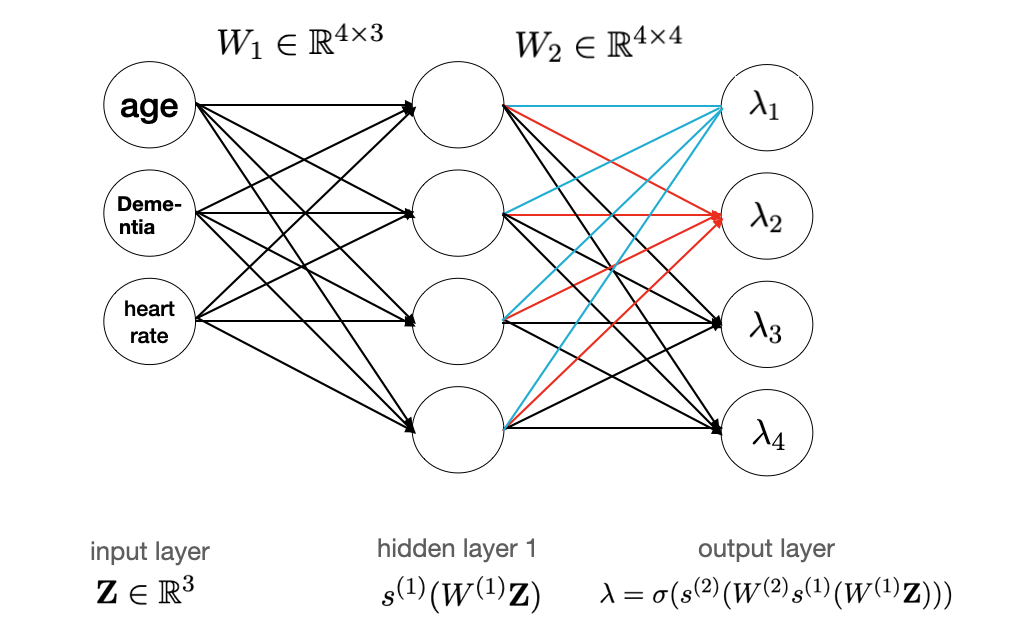

See the red and blue lines for weights connecting to $\lambda_1, \lambda_2$, where $ \lambda_1$ means the hazard value at time point $\tau_1$, $\lambda_2$ means the hazard value at time point $\tau_2$. You can see although the $\lambda_1, \lambda_2$ will be connected with all the nodes in the last layer, the weights are totally different and they vary with time, so we can understand it as a model $y = x^\top \beta(t)$, with $\beta(t)$ different initial values when they are connected with values at different time points.

---

Before we start, we need to generate the dataset. We use the SUPPORT data as an illustration.

In [6]:
local_data = read_data.support_data()

Since the time values in SUPPORT are continuous, we need to apply a transformation, from the continuous outcome to the discrete time values. 

However, if the data has already had discrete time values, no transformation is needed.

In [7]:
time_intervals = 20

labtrans, local_data = KLDL.cont_to_disc(local_data, time_intervals = time_intervals)

# Model Training

In this part we will train 3 models.

In [8]:
df_train = local_data.copy()

# Split the training, validation and test data

df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

# Determine the covariates that require preprocessing
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x3', 'x4', 'x5']
cols_categorical =  ['x2', 'x6']

# Wrap the covariates into a mapper
mapper = KLDL.mapper_generation(cols_standardize = cols_standardize, cols_leave = cols_leave, cols_categorical = cols_categorical)

# Use the mapper to generate input covariates and labels
x_train = mapper.fit_transform(df_train).astype('float32')
x_val = mapper.transform(df_val).astype('float32')
x_test = mapper.transform(df_test).astype('float32')

y_train = (df_train['duration'].values, np.array(df_train['event'].values, dtype = np.float32))
y_val = (df_val['duration'].values, np.array(df_val['event'].values, dtype = np.float32))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

In [9]:
parameter_set_local = {
    "hidden_nodes": 32,
    "hidden_layers": 2,
    "batch_norm": True,
    "learning_rate": 0.001,
    "batch_size": 64,
    "dropout": 0.1,
    "optimizer": tt.optim.Adam(),
    "alpha": 1,
    "sigma": 0.1
}

In [10]:
y_val[1].shape

(1413,)

In [11]:
# Train models
model_1, log_1 = KLDL.model_generation(x_train, x_val, y_train, y_val, with_prior = False, verbose = True, parameter_set = parameter_set_local, option = "logit")
model_2, log_2 = KLDL.model_generation(x_train, x_val, y_train, y_val, with_prior = False, verbose = True, parameter_set = parameter_set_local, option = "log-log-2")
model_3, log_3 = KLDL.model_generation(x_train, x_val, y_train, y_val, with_prior = False, verbose = True, parameter_set = parameter_set_local)

0:	[0s / 0s],		train_loss: 8.5939,	val_loss: 7.2279
1:	[0s / 0s],		train_loss: 6.2211,	val_loss: 4.5072
2:	[0s / 0s],		train_loss: 3.8539,	val_loss: 3.0381
3:	[0s / 0s],		train_loss: 2.9519,	val_loss: 2.7186
4:	[0s / 0s],		train_loss: 2.7408,	val_loss: 2.6780
5:	[0s / 1s],		train_loss: 2.7023,	val_loss: 2.6677
6:	[0s / 1s],		train_loss: 2.6844,	val_loss: 2.6670
7:	[0s / 1s],		train_loss: 2.6696,	val_loss: 2.6569
8:	[0s / 1s],		train_loss: 2.6734,	val_loss: 2.6470
9:	[0s / 1s],		train_loss: 2.6344,	val_loss: 2.6448
10:	[0s / 2s],		train_loss: 2.6359,	val_loss: 2.6282
11:	[0s / 2s],		train_loss: 2.6285,	val_loss: 2.6199
12:	[0s / 2s],		train_loss: 2.6126,	val_loss: 2.6152
13:	[0s / 2s],		train_loss: 2.5926,	val_loss: 2.6067
14:	[0s / 2s],		train_loss: 2.5900,	val_loss: 2.5986
15:	[0s / 3s],		train_loss: 2.5733,	val_loss: 2.5913
16:	[0s / 3s],		train_loss: 2.5641,	val_loss: 2.5848
17:	[0s / 3s],		train_loss: 2.5560,	val_loss: 2.5801
18:	[0s / 3s],		train_loss: 2.5417,	val_loss: 2.5702
19:

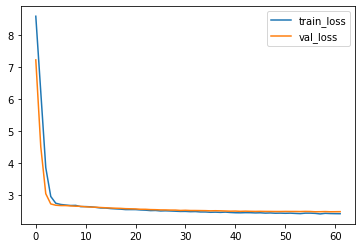

In [12]:
_ = log_1.plot()

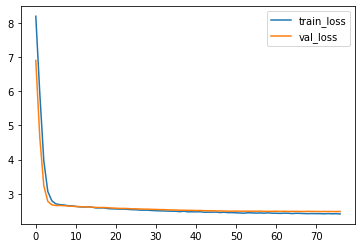

In [13]:
_ = log_2.plot()

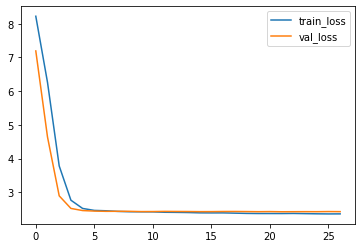

In [16]:
_ = log_3.plot()

# Evaluation

We evaluate our model using C-index, IBS and INBLL.

In [14]:
get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))

durations_test, events_test = get_target(df_test)

In [17]:
concordance_td_local, integrated_brier_score_local, integrated_nbll_local = KLDL.evaluation_metrics(x_test, durations_test, events_test, model_3)
concordance_td_prior, integrated_brier_score_prior, integrated_nbll_prior = KLDL.evaluation_metrics(x_test, durations_test, events_test, model_2, option = True)
concordance_td, integrated_brier_score, integrated_nbll = KLDL.evaluation_metrics(x_test, durations_test, events_test, model_1, option = True)

print("The C-index without link: ", concordance_td_local)
print("The C-index for log-log link: ", concordance_td_prior)
print("The C-index for logit link: ", concordance_td)
print("The IBS without link: ", integrated_brier_score_local)
print("The IBS for log-log link: ", integrated_brier_score_prior)
print("The IBS for logit link: ", integrated_brier_score)
print("The INBLL without link: ", integrated_nbll_local)
print("The INBLL for log-log link: ", integrated_nbll_prior)
print("The INBLL for logit link: ", integrated_nbll)


The C-index without link:  0.6474805270661292
The C-index for log-log link:  0.6213623944695715
The C-index for logit link:  0.6250091264366933
The IBS without link:  0.1687538880850537
The IBS for log-log link:  0.17366687448607196
The IBS for logit link:  0.17263426424192416
The INBLL without link:  0.5041890484383619
The INBLL for log-log link:  0.5188371295569224
The INBLL for logit link:  0.5179892078248453
